# Tutorials for Developing Scientific Workflows in Pycroscopy - Part 3: Handling Multidimensional datasets

#### Suhas Somnath
8/8/2017

This set of notebooks will serve as examples for developing end-to-end workflows for and using pycroscopy. 

__In this example, we will learn how to slice multidimensional datasets.__

## Introduction

In pycroscopy, all position dimensions of a dataset are collapsed into the first dimension and all other (spectroscopic) dimensions are collapsed to the second dimension to form a two dimensional matrix. The ancillary matricies, namely the spectroscopic indices and values matrix as well as the position indicies and values matrices will be essential for reshaping the data back to its original N dimensional form and for slicing multidimensional datasets

In [1]:
# downloading packages:
# !pip install -U wget numpy h5py matplotlib ipywidgets pycroscopy

# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# In case some of these packages are not installed, install them
#!pip install -U os wget numpy h5py matplotlib pycroscopy

# The package for accessing files in directories, etc.:
import os
import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# basic interactive widgets:
from ipywidgets import interact

# Finally import pycroscopy for certain scientific analysis:
import pycroscopy as px

# set up notebook to show plots within the notebook
% matplotlib inline

## Load the dataset

For this example, we will be working with a Band Excitation Polarization Switching (BEPS) First Order Reversal Curve (FORC) dataset acquired from advanced atomic force microscopes. In the much simpler Band Excitation (BE) imaging datasets, a single spectra is acquired at each location in a two dimensional grid of spatial locations. Thus, BE imaging datasets have two position dimensions (X, Y) and one spectroscopic dimension (frequency - against which the spectra is recorded). The BEPS-FORC dataset used in this example has a spectra for each combination of three other paramaters (DC offset, Field, bias waveform type {FORC}). Thus, this dataset has three new spectral dimensions in addition to the spectra itself. Hence, this dataet becomes a 2+4 = 6 dimensional dataset

In [2]:
# download the raw data file from Github:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/cades_dev/data/FORC_BEPS.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path)

In [3]:
# Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')

print('Datasets and datagroups within the file:\n------------------------------------')
px.hdf_utils.print_tree(h5_file)

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Bin_FFT
Measurement_000/Channel_000/Bin_Frequencies
Measurement_000/Channel_000/Bin_Indices
Measurement_000/Channel_000/Bin_Step
Measurement_000/Channel_000/Bin_Wfm_Type
Measurement_000/Channel_000/Excitation_Waveform
Measurement_000/Channel_000/Noise_Floor
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Guess
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Loop_Metrics
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Loop_Metr

In [5]:
h5_meas_grp = h5_file['Measurement_000']
h5_main = h5_meas_grp['Channel_000/Raw_Data']
print('\nThe main dataset:\n------------------------------------')
print(h5_main)


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (25, 62208), type "<c8">


The main dataset clearly does not provide the multidimensional information about the data that will be necessary to slice the data. For that we need the ancillary datasets that support this main dataset

In [6]:
# pycroscopy has a convenient function to access datasets linked to a given dataset:
h5_spec_ind = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]
h5_spec_val = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Values')[0]
h5_pos_ind = px.hdf_utils.getAuxData(h5_main, 'Position_Indices')[0]
h5_pos_val = px.hdf_utils.getAuxData(h5_main, 'Position_Values')[0]

### Understanding the ancillary datasets:

The position datasets are shaped as [spatial points, dimension] while the spectroscopic datasets are shaped as [dimension, spectral points]. Clearly the first axis of the position dataset and the second axis of the spectroscopic datasets match the correponding sizes of the main dataset.

Again, the sum of the position and spectroscopic dimensions results in the 6 dimensions originally described above.

Essentially, there is a unique combination of position and spectroscopic parameters for each cell in the two dimensionam main dataset. The interactive widgets below illustrate this point. The first slider represents the position dimension while the second represents the spectroscopic dimension. Each position index can be decoded to a set of X and Y indices and values while each spectroscopic index can be decoded into a set of frequency, dc offset, field, and forc parameters

In [35]:
print('Main Datasets of shape:', h5_main.shape)
print('Position Datasets of shape:', h5_pos_ind.shape)
print('Spectroscopic Datasets of shape:', h5_spec_ind.shape)

spec_labels = px.hdf_utils.get_formatted_labels(h5_spec_ind)
pos_labels = px.hdf_utils.get_formatted_labels(h5_pos_ind)

def myfun(pos_index, spec_index):
    for dim_ind, dim_name in enumerate(pos_labels):
        print(dim_name,':',h5_pos_ind[pos_index, dim_ind])
    for dim_ind, dim_name in enumerate(spec_labels):
        print(dim_name,':',h5_spec_ind[dim_ind, spec_index])
interact(myfun, pos_index=(0,h5_main.shape[0]-1, 1), spec_index=(0,h5_main.shape[1]-1, 1));

Main Datasets of shape: (25, 62208)
Position Datasets of shape: (25, 2)
Spectroscopic Datasets of shape: (4, 62208)


## Visualizing the ancillary datasets

The plots below show how the position and spectrocopic dimensions vary. Due to the high dimensionality of the spectroscopic dimensions, the variation of each dimension has been plotted separately.

#### How we interpret these plots:

__Positions__: For each Y index, the X index ramps up from 0 to 4 and repeats. Essentially, this means that for a given Y index, there were multiple measurments (different values of X)

__Spectroscopic__: The plot for `FORC` shows that the next fastest dimension - `DC offset` was varied 6 times. Correspondingly, the plot for `DC offset` plot shows that this dimension ramps up from 0 to a little less than 40 for each `FORC` index. This trend is the same for the faster varying dimensions - `Frequency` and `Field`. 

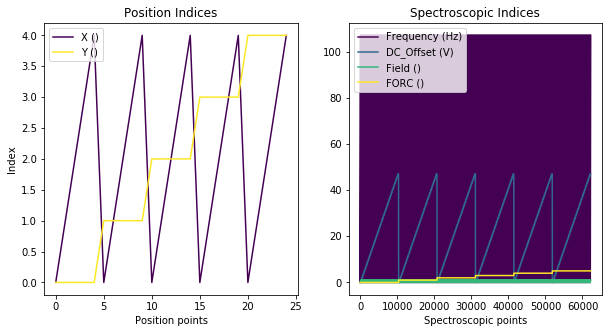

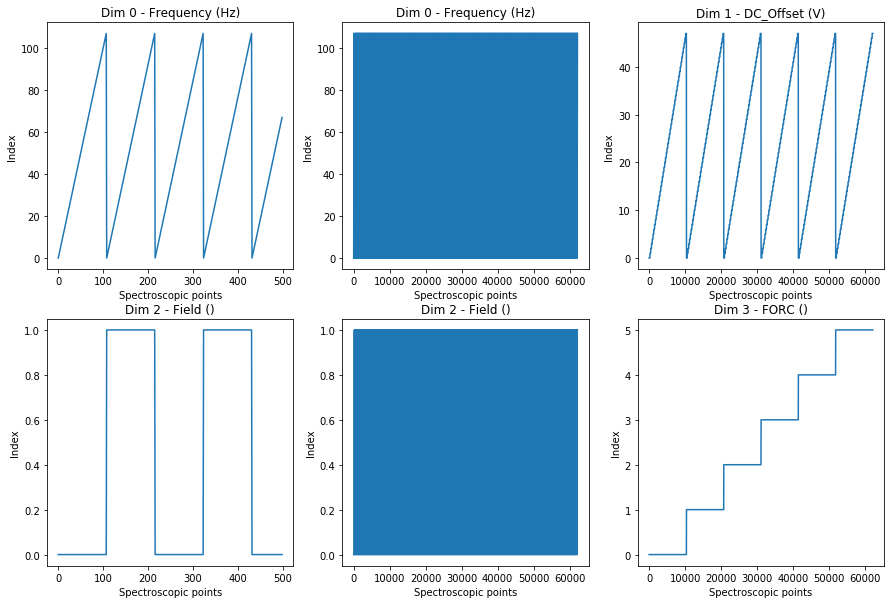

In [27]:
fig_1, axes = plt.subplots(ncols=2, figsize=(10,5))
px.plot_utils.plot_line_family(axes[0], np.arange(h5_pos_ind.shape[0]), h5_pos_ind[()].T, 
                               line_names=pos_labels)
axes[0].set_xlabel('Position points')
axes[0].set_ylabel('Index')
axes[0].set_title('Position Indices')
axes[0].legend()
px.plot_utils.plot_line_family(axes[1], np.arange(h5_spec_ind.shape[1]), h5_spec_ind, 
                               line_names=spec_labels)
axes[1].set_xlabel('Spectroscopic points')
axes[1].set_title('Spectroscopic Indices')
axes[1].legend()

fig_2, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for dim_ind, axis, dim_label, dim_array in zip([0,2], [axes.flat[0], axes.flat[3]], 
                                               [spec_labels[0], spec_labels[2]], 
                                               [h5_spec_ind[0,:500], h5_spec_ind[2,:500]]):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)
    
rhs_axes = [axes.flat[ind] for ind in [1,2,4,5]]
for dim_ind, axis, dim_label, dim_array in zip(range(h5_spec_ind.shape[0]), rhs_axes, spec_labels, h5_spec_ind):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)

In [ ]:
# A similar version of this function is available in pycroscopy.io.hdf_utils.get_formatted_labels
def describe_dimensions(h5_aux):
    for name, unit in zip(px.hdf_utils.get_attr(h5_aux, 'labels'),
                            px.hdf_utils.get_attr(h5_aux, 'units')):
        print(name, '[', unit, ']')

print('Position dimension names and units:')
describe_dimensions(h5_pos_ind)

print('\nSpectrocopic dimension names and units:')
describe_dimensions(h5_spec_ind)   

## Now lets find the size in each dimension
For now lets assume that data is sampled at each position and at each spectral step
In other words lets assume that data was not sampled over a random subset of points within a grid of points

In [ ]:
# The function below has been implemented as pycroscopy.io.hdf_utils.get_dimensionality
def get_dim_sizes(ind_dset, is_position=False):
    # ind_dset here is expected to be of the shape [dimension, points] like the spectroscopic indices
    if is_position:
        # Position dimensions will be turned from [points, dimension] to [dimension, points]
        ind_dset = np.transpose(ind_dset[()])
        
    dim_size = []
    for col in ind_dset:
        # For each dimension array, we will find the number of unique elements in it
        dim_size.append(len(np.unique(col)))
    return dim_size

pos_dim_sizes = get_dim_sizes(h5_pos_ind, is_position=True)
spec_dim_sizes = get_dim_sizes(h5_spec_ind)

print('Positions:',pos_dim_sizes, '\nSpectroscopic:', spec_dim_sizes)